In [97]:
# Uncomment and run this cell if you don't have DEAP or matplotlib installed (or haven't ran requirements.txt yet).
# !pip install deap matplotlib matplotlib

In [98]:
# Import necessary libraries
import random

from deap import creator, base, tools

import data_store.street_fighter.letters as letters

In [99]:
# Set letters to the desired value
LETTERS = letters.SIMPLE_LETTERS

In [100]:
word_frequencies={
    "→LP": 10,
    "↓LP": 5,
    "→HP": 5,
    "→LK": 10,
    "↓LK": 5,
    "MK": 5,
    "HK": 5,
    "→": 10,
    "←": 15,
    "↑": 10,
    "↓": 10,
    "LPLK": 20,
    "MKHP": 20,
    "↓→LK": 15000,
}

In [101]:
# Define hitbox layout
button_positions = {
    "←": (0, 0),   # Left directional
    "→": (2, 0),   # Right directional
    "↓": (1, 0),   # Down directional
    "↑": (1, 1),   # Up directional

    "LP": (5, 0),  # Light punch
    "MP": (6, 0),  # Medium punch
    "HP": (7, 0),  # Heavy punch
    "LK": (5, 1),  # Light kick
    "MK": (6, 1),  # Medium kick
    "HK": (7, 1),  # Heavy kick
}

# Manhattan distance calculation function
def manhattan_distance(pos1, pos2):
    x1, y1 = pos1
    x2, y2 = pos2
    return abs(x1 - x2) + abs(y1 - y2)


In [102]:
def calculate_distance(layout, frequencies):
    positions = {letter: idx for idx, letter in enumerate(layout)}
    total_distance = 0
    missing_buttons = set()

    # Check for missing buttons
    for letter in frequencies:
        if letter not in positions:
            missing_buttons.add(letter)
    
    if missing_buttons:
        total_distance += 10000  # Penalize for missing buttons

    # Calculate distance if no missing buttons
    if not missing_buttons:
        for combo, freq in frequencies.items():
            if all(char in positions for char in combo):
                dist = sum(abs(positions[combo[i]] - positions[combo[i+1]]) for i in range(len(combo)-1))
                total_distance += freq * dist

    return total_distance,


In [103]:
# Create the Optimization Problem
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)


C:\Users\jackj\anaconda3\envs\LeverlessKO\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\jackj\anaconda3\envs\LeverlessKO\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [104]:
# Define a Custom Crossover Function
def cxOnePoint(ind1, ind2):
    if len(ind1) != len(ind2):
        raise ValueError("Individuals must have the same length.")
    
    size = len(ind1)
    cxpoint = random.randint(1, size - 1)  # Ensure cxpoint is within range

    ind1[cxpoint:], ind2[cxpoint:] = ind2[cxpoint:], ind1[cxpoint:]
    return ind1, ind2


In [105]:
# Define a Custom Mutation Function
def mutShuffleIndexes(individual, indpb):
    """Shuffle mutation for list-based individuals while ensuring no letters are missing."""
    size = len(individual)
    if size <= 1:
        return individual,

    if random.random() < indpb:
        indexes = list(range(size))
        random.shuffle(indexes)
        shuffled_individual = [individual[i] for i in indexes]

        # Ensure all required buttons are still present
        if set(LETTERS) == set(shuffled_individual):
            return shuffled_individual,
        else:
            return individual,

    return individual,

In [106]:
# Enforce mutation
def validate_individual(individual):
    """Check if the individual contains all required buttons."""
    return set(LETTERS) == set(individual)

def mutate_with_validation(individual, indpb):
    """Mutation function with validation to ensure all buttons are present."""
    individual, = mutShuffleIndexes(individual, indpb)
    if validate_individual(individual):
        return individual,
    else:
        return individual,

In [107]:
# Initialize Individuals and Population
def init_individual():
    # Initialize an individual with a random permutation of the letters
    layout = LETTERS[:]
    random.shuffle(layout)
    return creator.Individual(layout)

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [108]:
# Define the Genetic Operators
toolbox.register("evaluate", calculate_distance, frequencies=word_frequencies)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", mutate_with_validation, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

In [109]:
# Validate the population
def validate_individual(individual):
    if set(individual) != set(LETTERS):
        print(f"Invalid individual detected: {individual}")
        return False
    return True

In [110]:
# Evaluate Invalid Fitness
def evaluate_population(population, toolbox):
    for ind in population:
        if not validate_individual(ind):
            print(f"Warning: Invalid individual {ind}")
        if not ind.fitness.valid or len(ind.fitness.values) == 0:
            ind.fitness.values = toolbox.evaluate(ind)
            if not isinstance(ind.fitness.values, tuple) or len(ind.fitness.values) == 0:
                print(f"Warning: Fitness values for individual {ind} are invalid or empty")
    return population


In [111]:
# Debug Fitness Values
def debug_fitness(population):
    for ind in population:
        if not isinstance(ind.fitness.values, tuple):
            print(f"Warning: Fitness values for individual {ind} are not a tuple")
        if len(ind.fitness.values) == 0:
            print(f"Warning: Fitness values for individual {ind} are empty")
        else:
            print(f"Individual: {ind}, Fitness: {ind.fitness.values}")


In [112]:
def main():
    # Set DEAP parameters
    population = toolbox.population(n=100)
    NGEN = 50
    CXPB, MUTPB = 0.5, 0.2

    print("Starting the optimization")

    best_individual = None
    best_fitness = float('inf')

    for gen in range(NGEN):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                try:
                    toolbox.mate(child1, child2)
                except IndexError as e:
                    print(f"IndexError during mating: {e}")
                    print(f"Child1: {child1}, Child2: {child2}")
                    continue
                del child1.fitness.values
                del child2.fitness.values

        # Apply mutation
        for mutant in offspring:
            if random.random() < MUTPB:
                try:
                    toolbox.mutate(mutant)
                except IndexError as e:
                    print(f"IndexError during mutation: {e}")
                    print(f"Mutant: {mutant}")
                    continue
                del mutant.fitness.values

        # Evaluate fitness values
        population = evaluate_population(population, toolbox)
        # debug_fitness(population)

        # Update the population
        population[:] = toolbox.select(population + offspring, len(population))

        # Print statistics and track the best individual
        try:
            fits = [ind.fitness.values[0] for ind in population]
        except IndexError as e:
            print(f"IndexError while accessing fitness values: {e}")
            continue

        length = len(population)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5

        # Find the best individual
        current_best = min(population, key=lambda ind: ind.fitness.values[0])
        current_best_fitness = current_best.fitness.values[0]
        if current_best_fitness < best_fitness:
            best_fitness = current_best_fitness
            best_individual = current_best

        print(f"Generation {gen}: Min {min(fits)} | Max {max(fits)} | Avg {mean} | Std {std}")

    print(f"Best Individual: {best_individual}")
    print(f"Best Fitness: {best_fitness}")

    return best_individual, best_fitness

In [113]:
best_individual, best_fitness = main()

Starting the optimization
Invalid individual detected: ['LK', 'MP', 'MK', 'HP', '↑', 'HK', '↓', 'LP', '←', 'LK']
Invalid individual detected: ['HK', '↑', 'MP', 'MK', 'LK', 'HP', '↓', '→', '←', 'HK']
Invalid individual detected: ['MP', 'LP', 'LK', 'LP', '↑', 'MK', '→', '←', 'HP', 'MP']
Invalid individual detected: ['LP', 'HK', '↓', 'HK', 'MK', '→', '↑', '←', 'HP', 'LK']
Invalid individual detected: ['↓', 'MP', '↑', 'HK', '→', 'MK', '↑', '↓', 'HK', 'LK']
Invalid individual detected: ['←', 'LK', 'LP', '↓', 'HP', 'HK', '→', 'MP', 'LK', '←']
Invalid individual detected: ['MK', 'HK', '↓', 'MK', 'LP', 'LK', 'MP', '↑', '→', 'HK']
Invalid individual detected: ['↑', 'MP', 'MK', 'HK', '→', 'HP', '←', 'HK', '→', 'LP']
Invalid individual detected: ['←', '→', 'MP', 'LP', '↓', 'MP', '↑', 'HK', '→', 'LP']
Invalid individual detected: ['↑', '←', 'LP', 'HP', '→', 'MK', '↑', '↓', 'HK', 'LK']
Invalid individual detected: ['↑', '←', 'LP', 'HP', '→', 'LK', 'MP', 'HK', 'HP', 'LP']
IndexError while accessing 

Index: 0, Button: LP, Position: (0, 0)
Index: 1, Button: ↓, Position: (2, 0)
Index: 2, Button: MP, Position: (1, 0)
Index: 3, Button: LP, Position: (1, 1)
Index: 4, Button: ↑, Position: (5, 0)
Index: 5, Button: HK, Position: (6, 0)
Index: 6, Button: HP, Position: (7, 0)
Index: 7, Button: MK, Position: (5, 1)
Index: 8, Button: ↓, Position: (6, 1)
Index: 9, Button: LK, Position: (7, 1)


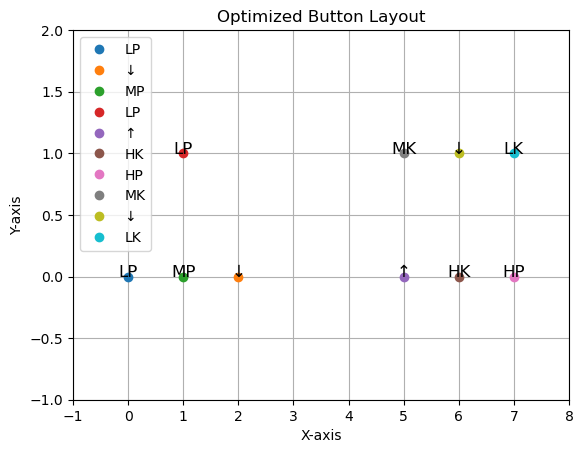

In [114]:
import matplotlib.pyplot as plt

# Visualize the layout on the hitbox controller
def plot_layout(layout, grid):
    # Check if the lengths match
    if len(layout) != len(grid):
        raise ValueError("Length of optimized_layout does not match the number of hitbox positions")
    
    # Create a figure and axis
    fig, ax = plt.subplots()
    
    # Plot the optimized positions
    for idx, button in enumerate(layout):
        # Ensure the index is within range
        if idx >= len(grid):
            raise IndexError("Index out of range when accessing hitbox_grid positions")
    
        pos = list(grid.keys())[idx]  # Get the position from the grid
        pos=grid[pos]
        
        # Debugging output
        print(f"Index: {idx}, Button: {button}, Position: {pos}")
    
        ax.plot(pos[0], pos[1], 'o', label=button)  # Plot each button
        ax.text(pos[0], pos[1], button, fontsize=12, ha='center')
    
    # Set grid and labels
    ax.grid(True)
    ax.set_xlim(-1, 8)
    ax.set_ylim(-1, 2)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Optimized Button Layout')
    ax.legend()
    
    plt.show()


# Example usage with the best individual
plot_layout(best_individual, button_positions)


In [115]:
print(best_individual)

['LP', '↓', 'MP', 'LP', '↑', 'HK', 'HP', 'MK', '↓', 'LK']
